In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [2]:
dataset = MNIST(root='data/',download=True)

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# dataset

In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/',train=False)
len(test_dataset)

10000

In [5]:
type((dataset[0])[0])

PIL.Image.Image

# plot image

label: 5
<class 'PIL.Image.Image'>


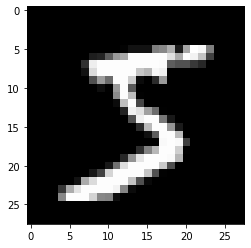

In [6]:
image, label = dataset[0]
plt.imshow(image,cmap='gray')
print('label:',label)
print(type(image))

label: 3


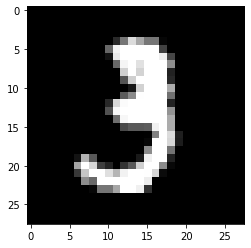

In [7]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('label:',label)

# transform into tensors

AS pil.img.... such format is not reciognised by torch we have to conver data into tensor.


In [8]:
dataset = MNIST(root='data/',train=True, transform=transforms.ToTensor())

In [9]:
image_tensor, label = dataset[0]
print(image_tensor.shape,label)
image_tensor.dtype

torch.Size([1, 28, 28]) 5


torch.float32

In [10]:
type(dataset)

torchvision.datasets.mnist.MNIST

In [11]:
type(dataset[0])

tuple

In [12]:
type(label)

int

In [13]:
print(image_tensor[0,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


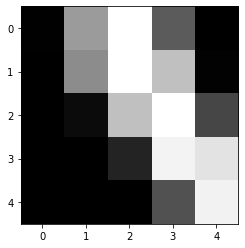

In [14]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(image_tensor[0,10:15,10:15], cmap='gray')

### split for validation set

In [15]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
print(len(train_ds), len(val_ds), type((train_ds)), type(train_ds[0][0]), type((train_ds[0])[1]))

50000 10000 <class 'torch.utils.data.dataset.Subset'> <class 'torch.Tensor'> <class 'int'>


### create DataLoader

In [16]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [17]:
print(type(train_loader))
train_loader[0]

<class 'torch.utils.data.dataloader.DataLoader'>


TypeError: 'DataLoader' object is not subscriptable

In [21]:
for images,labels in train_loader:
    print(type(images))
    #print(type(images[0].squeeze()))
    print(images.dtype)
    print(images.shape)
    print(type(label))
    break

<class 'torch.Tensor'>
torch.float32
torch.Size([128, 1, 28, 28])
<class 'int'>


In [22]:
lp = torch.tensor([[1,2,3,5,4,6,0]])
print(torch.max(lp,1))

torch.return_types.max(
values=tensor([6]),
indices=tensor([5]))


# model

In [49]:
import torch.nn as nn
import torch.nn.functional as F
input_size = 28*28
num_classes = 10

# Logistic regression model

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [94]:
class mnistlogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,num_classes,bias=True)
        
    def forward(self,x):
        x = x.reshape(-1,784)
        out = self.lin(x)
        return out
        
    def training_step(self,current_batch):
        images,labels = current_batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,current_batch):
        images,labels = current_batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out, labels)
        return {'validation_loss':loss, 'validation_accuracy':acc}
        
    def validation_results_at_end_of_epoch(self,val_outputs):
        batch_losses = [x['validation_loss'] for x in val_outputs]
        batch_accuracy = [x['validation_accuracy'] for x in val_outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss':epoch_losses,'val_acc': epoch_accuracy}
        
    def result_of_epoch(self, epoch, result):
        print("epoch[{}],val_loss:{:.4f},val_acc:{:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
model = mnistlogistic()

In [95]:
def evaluate(model, val_loader):
    val_outputs = [model.validation_step(current_batch) for current_batch in val_loader]
    return model.validation_results_at_end_of_epoch(val_outputs)

In [96]:
def fit(epochs,lr, model, train_loader,val_loader, optimizer_fn):
    optimizer = optimizer_fn(model.parameters(),lr)
    for epoch in range(epochs):
        
        # Training Phase 
        for current_batch in train_loader:
            loss = model.training_step(current_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.result_of_epoch(epoch, result)

In [97]:
optimizer_fn = torch.optim.SGD
lr = 0.001
epochs=5

In [98]:
fit(5,lr,model,train_loader,val_loader,optimizer_fn)

epoch[0],val_loss:1.9374,val_acc:0.6427
epoch[1],val_loss:1.6700,val_acc:0.7266
epoch[2],val_loss:1.4713,val_acc:0.7567
epoch[3],val_loss:1.3215,val_acc:0.7776
epoch[4],val_loss:1.2064,val_acc:0.7936


In [99]:
fit(5,lr,model,train_loader,val_loader,optimizer_fn)

epoch[0],val_loss:1.1161,val_acc:0.8048
epoch[1],val_loss:1.0434,val_acc:0.8125
epoch[2],val_loss:0.9838,val_acc:0.8192
epoch[3],val_loss:0.9342,val_acc:0.8254
epoch[4],val_loss:0.8923,val_acc:0.8291


In [100]:
fit(5,lr,model,train_loader,val_loader,optimizer_fn)

epoch[0],val_loss:0.8563,val_acc:0.8322
epoch[1],val_loss:0.8251,val_acc:0.8353
epoch[2],val_loss:0.7978,val_acc:0.8386
epoch[3],val_loss:0.7736,val_acc:0.8420
epoch[4],val_loss:0.7521,val_acc:0.8440


In [108]:
fit(5,lr,model,train_loader,val_loader,optimizer_fn)

epoch[0],val_loss:0.7327,val_acc:0.8461
epoch[1],val_loss:0.7153,val_acc:0.8475
epoch[2],val_loss:0.6995,val_acc:0.8490
epoch[3],val_loss:0.6850,val_acc:0.8508
epoch[4],val_loss:0.6718,val_acc:0.8521


In [109]:
fit(5,lr,model,train_loader,val_loader,optimizer_fn)

epoch[0],val_loss:0.6596,val_acc:0.8531
epoch[1],val_loss:0.6483,val_acc:0.8546
epoch[2],val_loss:0.6379,val_acc:0.8567
epoch[3],val_loss:0.6282,val_acc:0.8578
epoch[4],val_loss:0.6191,val_acc:0.8585


In [103]:
for images, labels in train_loader:
    print(images.dtype)
    print(images.shape)
    images = images.reshape(128,784)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

torch.float32
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
tensor([[-1.2110,  0.7196,  0.4692,  ...,  0.9332,  0.3337,  0.6773],
        [-0.9301, -1.1137, -0.8745,  ..., -0.8416,  1.1152, -0.7690],
        [-0.6272, -1.2898,  0.5728,  ...,  0.6817, -0.9408,  0.4669],
        ...,
        [-0.0352, -0.3531,  2.6772,  ..., -1.7633,  1.2246, -0.3265],
        [-1.9310,  1.1844, -1.1100,  ...,  2.4095,  0.2934,  1.0368],
        [ 5.3657, -3.4268, -1.2581,  ..., -0.0303, -1.0657, -0.9323]],
       grad_fn=<AddmmBackward>)


In [104]:
type(train_loader),type(image)

(torch.utils.data.dataloader.DataLoader, PIL.Image.Image)

In [105]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-1.0317, -1.3401,  0.1352,  1.3187,  0.0421,  0.0580, -0.8595,  1.3999,
         -0.1668,  0.6947],
        [ 2.6068, -2.2707, -0.1219, -1.4089, -0.7622,  1.2450, -0.8690, -0.8487,
          2.0016,  0.5252]])


In [106]:
outputs[:2]

tensor([[-1.0317, -1.3401,  0.1352,  1.3187,  0.0421,  0.0580, -0.8595,  1.3999,
         -0.1668,  0.6947],
        [ 2.6068, -2.2707, -0.1219, -1.4089, -0.7622,  1.2450, -0.8690, -0.8487,
          2.0016,  0.5252]], grad_fn=<SliceBackward>)

In [107]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0239, 0.0175, 0.0767, 0.2504, 0.0699, 0.0710, 0.0284, 0.2715, 0.0567,
         0.1342],
        [0.4729, 0.0036, 0.0309, 0.0085, 0.0163, 0.1212, 0.0146, 0.0149, 0.2582,
         0.0590]])
Sum:  1.0
